In [1]:
from __future__ import division
from __future__ import print_function

import sys
import os
import argparse
import time
import random
from glob import glob

import align.detect_face
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import misc
from scipy.interpolate import Rbf
from skimage import io, transform
from six.moves import xrange

import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib import resampler
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.ops import array_ops

import facenet
import helper

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion() # interactive mode

# Load Landmarks


In [2]:
#임베딩, 학습, 테스트 할 경우 반드시 실행
#landmarks_frame = pd.read_csv('./face_landmarks_detects.csv')
landmarks_frame = pd.read_csv('./face_landmarks.csv')
file_list = landmarks_frame.image_name.values.tolist()

In [3]:
n = 80
img_name = landmarks_frame.ix[n, 0]
image = io.imread(os.path.join('', img_name))
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2) # (68, 2)

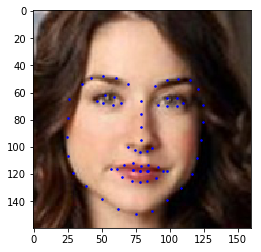

In [4]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='b')
    plt.pause(0.001)

plt.figure()
show_landmarks(image, landmarks)
plt.show()

In [5]:
print(landmarks_frame.ix[n, 0])

./faces_resize/002609.jpg


In [6]:
print(len(file_list))

954


# Hyperparameter

임베딩, 학습, 테스트 할 경우 반드시 실행

In [3]:
avgP_num = 1792
batch_size = 100
f_num = 1792
l_num = 68

# Embeding Facenet

'f_emb_list.npz', 'f_avgP_list.npz' 파일이 있는 경우 
아래 Load Facenet Embedings 부터 실행하면 됨

In [8]:
def load_and_align_data(image_paths, image_size, margin, gpu_memory_fraction):

    minsize = 20 # minimum size of face
    threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
    factor = 0.709 # scale factor
    
    print('Creating networks and loading parameters')
    with tf.Graph().as_default():
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
        with sess.as_default():
            pnet, rnet, onet = align.detect_face.create_mtcnn(sess, None)
  
    nrof_samples = len(image_paths)
    img_list = [None] * nrof_samples
    for i in range(nrof_samples):
        img = misc.imread(os.path.expanduser(image_paths[i]))
        if (img.shape[2] == 4):
            img = img[:, :, :3]
        img_size = np.asarray(img.shape)[0:2]
        bounding_boxes, _ = align.detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
        det = np.squeeze(bounding_boxes[0,0:4])
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin/2, 0)
        bb[1] = np.maximum(det[1]-margin/2, 0)
        bb[2] = np.minimum(det[2]+margin/2, img_size[1])
        bb[3] = np.minimum(det[3]+margin/2, img_size[0])
        cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
        aligned = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
        prewhitened = facenet.prewhiten(aligned)
        img_list[i] = prewhitened
        sys.stdout.write('\r'+ '%d/%d'%(i, nrof_samples))
    images = np.stack(img_list)
    return images

In [9]:
f_emb_g = tf.Graph()
f_emb_list = []
f_avgP_list = []

In [97]:
with f_emb_g.as_default():
    time_load_data = time.time()
    print("--- data loading start ---")
    images = load_and_align_data(file_list, 160, 44, 1.0)
    print("--- %s data loaded ---" % (time.time() - time_load_data))
    
    with tf.Session() as sess:
        start_load_facenet = time.time()
        print("--- %s start load facenet ---" % (start_load_facenet))
        facenet.load_model('./20170512-110547')
        print("--- %s facenet loaded ---" % (time.time() - start_load_facenet))

        # Get input and output tensors
        f_inputs = tf.get_default_graph().get_tensor_by_name("input:0")
        f_phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        f_avgP_logits = tf.get_default_graph().get_tensor_by_name("InceptionResnetV1/Logits/AvgPool_1a_8x8/AvgPool:0")
        f_emb_logits = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        
        start_test = time.time()
        
        total_size = len(images)
        for i in range(0, total_size, batch_size):
            batch = images[i:min(i+batch_size, total_size)]
            f_feed = {f_inputs: batch, f_phase_train_placeholder:False}
            f_embedings, f_avgPool = sess.run([f_emb_logits, f_avgP_logits], feed_dict=f_feed)
            f_emb_list.append(f_embedings)
            f_avgP_list.append(f_avgPool)
            sys.stdout.write('\r'+ "[%d/%d] %s" % (i, total_size, time.time() - start_test))
            print()
        print("--- %s seconds ---" % (time.time() - start_test))

--- data loading start ---
Creating networks and loading parameters
7388/7389--- 265.97134256362915 data loaded ---
--- 1506939013.9509783 start load facenet ---
Model directory: ./20170512-110547
Metagraph file: model-20170512-110547.meta
Checkpoint file: model-20170512-110547.ckpt-250000
INFO:tensorflow:Restoring parameters from ./20170512-110547/model-20170512-110547.ckpt-250000
--- 58.02926468849182 facenet loaded ---
[0/7389] 8.392938137054443
[100/7389] 14.859272480010986
[200/7389] 21.36845302581787
[300/7389] 27.851694107055664
[400/7389] 34.36852049827576
[500/7389] 40.84961199760437
[600/7389] 47.416656255722046
[700/7389] 53.90496468544006
[800/7389] 60.4436297416687
[900/7389] 66.88116526603699
[1000/7389] 73.35184860229492
[1100/7389] 79.82700967788696
[1200/7389] 86.28891849517822
[1300/7389] 92.7585060596466
[1400/7389] 99.23664498329163
[1500/7389] 105.6737744808197
[1600/7389] 112.12060689926147
[1700/7389] 118.61604189872742
[1800/7389] 125.11889004707336
[1900/7389] 

In [11]:
#임베딩 결과 저장
np.savez('f_emb_list.npz', *f_emb_list)
np.savez('f_avgP_list.npz', *f_avgP_list)

# Load Facenet Embedings

In [4]:
container = np.load('f_avgP_list.npz')
train_set = []
test_set = []
for key in sorted(container, key=lambda x: int(x.strip('arr_'))) :
    #print(key)
    batch = container[key]
    if len(batch) is batch_size :
        train_set.append(batch)
    else :
        test_set.append(batch)

test_set = train_set
#train_set = train_set[:30]
test_set_index = len(train_set)

In [5]:
print(len(test_set))
print(len(train_set))

9
9


In [6]:
print(test_set_index)

9


# Landmark Training Test

In [7]:
from datetime import datetime

In [8]:
base_dir = os.path.expanduser('logs')
subdir = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')
log_dir = os.path.join(base_dir, subdir)

In [10]:
#loss_file_name = log_dir + "/loss_xv.txt"
#loss_file_name = log_dir + "/loss_rsma.txt"
#loss_file_name = log_dir + "/loss_xv_bn_3.txt"
loss_file_name = log_dir + "/loss.txt"

def make_path(file_name) :
    if not os.path.exists(os.path.dirname(file_name)):
        try:
            os.makedirs(os.path.dirname(file_name))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    return file_name

make_path(loss_file_name)

'logs/20171031-010334/loss.txt'

In [11]:
def l_init() :
    return tf.contrib.layers.variance_scaling_initializer()

In [12]:
# def fc_bn(prev_layer, num_units, is_training=False, scope=None) :
#     with tf.variable_scope(scope, 'fc') :
#         layer = tf.layers.dense(prev_layer, 
#                                 num_units, 
#                                 kernel_initializer=l_init(), 
#                                 activation=None)
#         layer = tf.layers.batch_normalization(layer, training=is_training)
#         layer = tf.nn.relu(layer)
#     return layer

In [13]:
def F_layer(net, f_num = 1024, is_training=False) : 
    with tf.variable_scope('F') :
        net = slim.fully_connected(net, f_num, weights_initializer=l_init(),scope='fc0')
#         net = slim.fully_connected(net, f_num, weights_initializer=l_init(),scope='fc1')
#         net = slim.fully_connected(net, f_num, weights_initializer=l_init(),scope='fc2')
    return net

In [91]:
def MLP(net, landmark_num = 68, is_training=False, reuse=None, scope='MLP'):
    """Builds the MLP for landmark"""
    with tf.variable_scope(scope, 'MLP') :
        net = slim.fully_connected(net, 1024, weights_initializer=l_init(), scope='fc0')
        net = slim.fully_connected(net, 512, weights_initializer=l_init(), scope='fc1')
        net = slim.fully_connected(net, 256, weights_initializer=l_init(), scope='fc2')
        net = slim.fully_connected(net, 128, weights_initializer=l_init(), scope='fc3')
        net = slim.fully_connected(net, landmark_num, activation_fn=None, weights_initializer=l_init(), scope='fc4')
    return net

In [92]:
def landmark_decode(net, landmark_num = 68, is_training=False):
    with tf.variable_scope('landmark') :
        decoded_x = MLP(net, is_training=is_training, scope= 'decoded_x')
        decoded_y = MLP(net, is_training=is_training, scope= 'decoded_y')
    return decoded_x, decoded_y

In [93]:
# if embeding is done, start from here

In [94]:
l_epochs = 100
l_g = tf.Graph()

In [95]:
with l_g.as_default():
    l_inputs = tf.placeholder(tf.float32, (None, avgP_num), name='l_inputs')
    l_x_labels = tf.placeholder(tf.float32, (None, l_num), name='l_x_labels')
    l_y_labels = tf.placeholder(tf.float32, (None, l_num), name='l_y_labels')
    
    is_training = tf.placeholder(tf.bool)
    
    F = F_layer(l_inputs, f_num= f_num, is_training=is_training)
    (l_x_preds, l_y_preds) = landmark_decode(F, is_training=is_training)
    
    l_x_loss = tf.losses.mean_squared_error(l_x_labels, l_x_preds, reduction="weighted_mean")
    l_y_loss = tf.losses.mean_squared_error(l_y_labels, l_y_preds, reduction="weighted_mean")
    
    total_cost = tf.add(l_x_loss, l_y_loss)
    opt = tf.train.AdamOptimizer(0.001).minimize(total_cost)
#     extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#     with tf.control_dependencies(extra_update_ops):
#         opt = tf.train.AdamOptimizer(0.001).minimize(total_cost)

In [96]:
def l_show_test(l_x, l_y, n):
    index = n[0] * batch_size + n[1] #(len(train_set) + n[0]) * batch_size + n[1]
    img_name = landmarks_frame.ix[index, 0]
    landmarks = landmarks_frame.ix[index, 1:].as_matrix().astype('float').reshape(-1, 2)
    
    plt.figure()
    plt.imshow(io.imread(os.path.join('', img_name)))
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='b')
    plt.scatter(l_x, l_y, s=10, marker='.', c='r')
    plt.show()

In [97]:
print(len(train_set))
print(test_set_index)

768
768


0


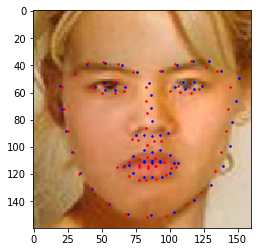

1


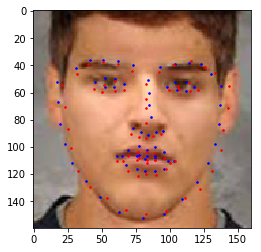

2


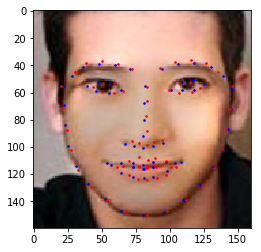

3


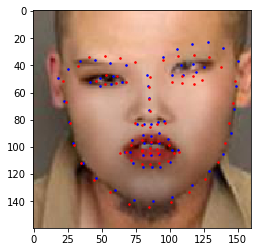

4


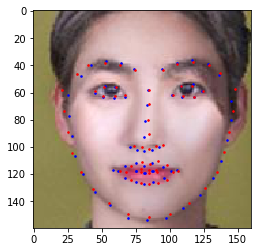

KeyboardInterrupt: 

In [98]:
with l_g.as_default():
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
                
        start_test = time.time()
        
        for e in range(l_epochs):
            for i, f_avgP in enumerate(train_set):
                start = i * batch_size
                end = min(start+batch_size, len(train_set) * batch_size)
                size = end - start
                
                l_labels = landmarks_frame.ix[start:end - 1, 1:].as_matrix().astype('float').reshape(-1, 2)
                l_feed = {l_inputs : f_avgP.reshape(-1, avgP_num),
                          l_x_labels : l_labels[:, 0].reshape(-1, l_num), 
                          l_y_labels : l_labels[:, 1].reshape(-1, l_num), 
                          is_training : True}
                
                x_cost, y_cost, _ = sess.run([l_x_loss, l_y_loss, opt], l_feed)
                # x_cost, y_cost, _, _ = sess.run([l_x_loss, l_y_loss, opt_x, opt_y], l_feed)
                log = "Epoch: {}/{}...".format(e+1, l_epochs)
                log += "Training loss: X = {:.4f}, Y = {:.4f}".format(x_cost / size, y_cost / size)
                f = open(loss_file_name, "a")
                f.write(log +'\n')
                f.close

#             if (e+1)%10 == 0 :
            print(e)
            test_index = (random.randint(0, len(test_set)-1),random.randint(0, len(test_set[0])-1))
            test_avgP = test_set[test_index[0]][test_index[1]]
            l_feed = {l_inputs : test_avgP.reshape(-1, avgP_num), 
                      is_training : False}
            l_x, l_y = sess.run([l_x_preds, l_y_preds], l_feed)
            l_show_test(l_x, l_y, test_index)
            
        print("Time: %s" % (time.time() - start_test))

        print("--- %s seconds ---" % (time.time() - start_test))
        

# Test Dataset Helper

In [14]:
t_dataset = helper.Dataset('nf',file_list, 160)
print(t_dataset.shape)

(954, 160, 160, 3)


In [27]:
data_dir = './faces_detects'
show_n_images = 25

In [28]:
nf_images = helper.get_batch(glob(os.path.join(data_dir, './*.jpg'))[:show_n_images], 96, 96, 'RGB')
plt.imshow(helper.images_square_grid(nf_images, 'RGB'))
# dataset = helper.Dataset('nf', glob(os.path.join(data_dir, 'mnist/*.jpg')))

AttributeError: module 'helper' has no attribute 'images_square_grid'

# Texture Training Test

In [15]:
def CNN(F, size, is_training=False) :
    with tf.variable_scope('CNN') :
        # 12 x 12 x 256
        f_size = int(size / 8)
        features = slim.fully_connected(F, f_size * f_size * 256, activation_fn=None, scope="features")
        features = tf.reshape(features, [-1, f_size, f_size, 256])
        # print(features.shape)
        
        # 24 x 24 x 128
        upsample_0 = slim.conv2d_transpose(features, 128, 5, stride=2, activation_fn=None, scope="upsample_0")
        upsample_0 = tf.layers.batch_normalization(upsample_0, training=is_training)
        upsample_0 = tf.nn.relu(upsample_0)
        # print(upsample_0.shape)
        
        # 48 x 48 x 64
        upsample_1 = slim.conv2d_transpose(upsample_0, 64, 5, stride=2, activation_fn=None,scope="upsample_1")
        upsample_1 = tf.layers.batch_normalization(upsample_1, training=is_training)
        upsample_1 = tf.nn.relu(upsample_1)
        # print(upsample_1.shape)
        
        # 96 x 96 x 32
        upsample_2 = slim.conv2d_transpose(upsample_1, 32, 5, stride=2,activation_fn=None, scope="upsample_2")
        upsample_2 = tf.layers.batch_normalization(upsample_2, training=is_training)
        upsample_2 = tf.nn.relu(upsample_2)
        # print(upsample_2.shape)
        
        # 96 x 96 x 3
        one_by_one_conv = slim.conv2d(upsample_2, 3, 1, stride=1, activation_fn=None, scope="one_by_one_conv")
        # print(one_by_one_conv.shape)
    return one_by_one_conv

In [16]:
def texture_decode(encoded, size, f_vector=128, is_training=False) :
    with tf.variable_scope('texture') :
        cnn = CNN(F, size, is_training=is_training)
    return cnn

In [17]:
epochs = 200
t_g = tf.Graph()

In [18]:
with t_g.as_default():
    t_inputs = tf.placeholder(tf.float32, (None, avgP_num), name='t_inputs')
    t_labels = tf.placeholder(tf.float32, (None, 160, 160, 3), name='t_labels')
    is_training = tf.placeholder(tf.bool)
    
    F = F_layer(t_inputs, f_num=f_num, is_training=is_training)
    t_preds = texture_decode(F, 160, is_training=is_training)
    t_loss = tf.losses.absolute_difference(t_labels, t_preds)
    opt = tf.train.AdamOptimizer(0.001).minimize(t_loss)

In [19]:
def t_show_test(t, n):
    label_file_name = file_list[n[0] * batch_size + n[1]]
    # print(t.shape)
    label_img = io.imread(os.path.join('', label_file_name))
    plt.imshow(label_img)
    plt.show()
    
    img = scipy.misc.toimage(t)
    plt.imshow(img)
    plt.show()

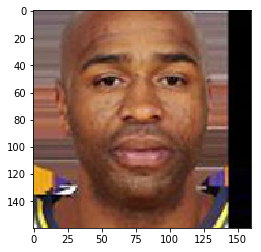

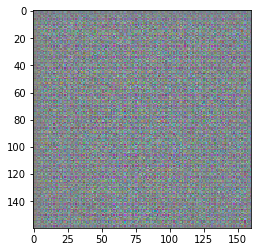

Time: 46.48876118659973


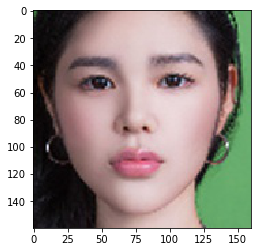

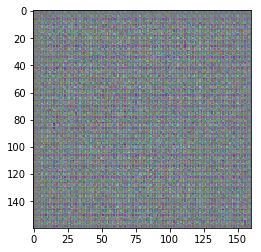

Time: 105.55430221557617


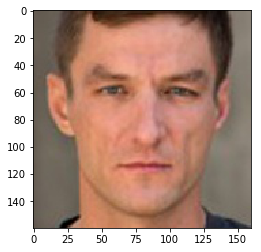

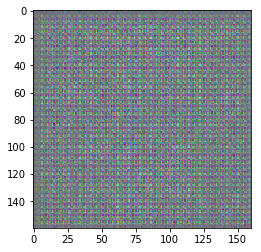

Time: 154.69588613510132


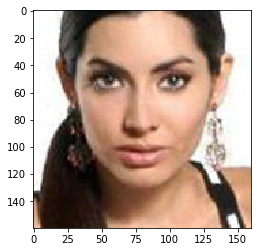

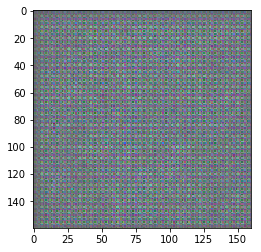

Time: 201.65301823616028


KeyboardInterrupt: 

In [21]:
with t_g.as_default():
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        start_test = time.time()
        for e in range(epochs):
            for i, (f_avgP, t_label_batch) in enumerate(zip(train_set, t_dataset.get_batches(batch_size))):
                t_feed = {t_inputs : f_avgP.reshape(-1, avgP_num),
                          t_labels : t_label_batch, 
                          is_training : True}
                loss, _ = sess.run([t_loss, opt], t_feed)
                # x_cost, y_cost, _, _ = sess.run([l_x_loss, l_y_loss, opt_x, opt_y], l_feed)
                if (i+1) % 1 == 0 :
                    log = "Epoch: {}/{}...".format(e+1, epochs)
                    log += "Training loss: {:.4f}".format(loss)
                    f = open(loss_file_name, "a")
                    f.write(log +'\n')
                    f.close
                    
                    test_index = (random.randint(0, len(test_set)-1),random.randint(0, len(test_set[0])-1))
                    test_avgP = test_set[test_index[0]][test_index[1]]
                    t_test_feed = {t_inputs : test_avgP.reshape(-1, avgP_num), 
                                   is_training : False}
                    t = sess.run(t_preds, t_test_feed)
                    t_show_test(t.reshape(160,160,3), test_index)
                    print("Time: %s" % (time.time() - start_test))

        print("--- %s seconds ---" % (time.time() - start_test))

# Warp Face

In [8]:
def get_warp_image(landmarks_frame) :
    index = random.randint(0, len(landmarks_frame)-1)
    name = landmarks_frame.ix[index, 0]
    image = io.imread(os.path.join('', name))
    
    landmarks = landmarks_frame.ix[index, 1:].as_matrix().astype('float')
    landmarks = landmarks.reshape(-1, 2) # (68, 2)
    
    return image, landmarks

In [9]:
def get_grids(size):
    return np.mgrid[0:size-1:(size * 1j), 0:size-1:(size * 1j)]

In [10]:
def get_zero_displacement(size, landmarks):
    mid = size/2
    end = size-1
    
    new_landmarks = np.copy(landmarks)
    new_landmarks[:, 0][27:31] += 5
#     new_landmarks[:, 1][27:31] += 5
    
    zero_displacement = [[0,0], 
                         [0, mid], 
                         [0, end], 
                         [mid, 0], 
                         [end,0], 
                         [end, mid], 
                         [end, end], 
                         [mid, end]]
    
    landmarks_with_zero_displacement = np.append(landmarks, zero_displacement, axis=0)
    new_landmarks_with_zero_displacement = np.append(new_landmarks, zero_displacement, axis=0)
    return landmarks_with_zero_displacement, new_landmarks_with_zero_displacement

In [11]:
def warp_scipy(image, landmarks, size) :
    grid_y, grid_x = get_grids(size)
    landmarks_with_zero_displacement, new_landmarks_with_zero_displacement = get_zero_displacement(size, landmarks)
    
    rbf_x = Rbf(new_landmarks_with_zero_displacement[:, 0], new_landmarks_with_zero_displacement[:, 1], landmarks_with_zero_displacement[:,0], epsilon=2, function='linear', smooth=1)
    ZI_x = rbf_x(grid_x, grid_y)

    rbf_y = Rbf(new_landmarks_with_zero_displacement[:, 0], new_landmarks_with_zero_displacement[:, 1], landmarks_with_zero_displacement[:,1], epsilon=2, function='linear', smooth=1)
    ZI_y = rbf_y(grid_x, grid_y)

    map_x = np.append([], [ar for ar in ZI_x]).reshape(size, size).astype('float32')
    map_y = np.append([], [ar for ar in ZI_y]).reshape(size, size).astype('float32')
    warped = cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)
    plt.imshow(warped)
    plt.show()

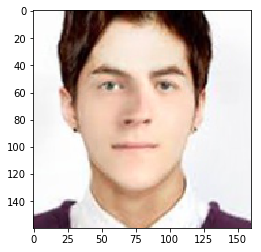

In [12]:
w_s_image, w_s_landmark = get_warp_image(landmarks_frame)
warp_scipy(w_s_image, w_s_landmark , 160)

In [13]:
def rbf_tf(pred_x, pred_y, correct_points, grids, grid_shape):
    def _euclidean_norm_tf(x1, x2):    
        euclidean_norm = tf.subtract(x1, x2)
        euclidean_norm = tf.square(euclidean_norm)
        euclidean_norm = tf.reduce_sum(euclidean_norm, 1)
        euclidean_norm = tf.add(euclidean_norm, 1e-10)
        #euclidean_norm = tf.clip_by_value(euclidean_norm, 0.1, 10**5)
        euclidean_norm = tf.sqrt(euclidean_norm)
        return euclidean_norm

    def _h_linear_tf(r):
        return r

    def _call_norm_tf(x1, x2):
        x1 = tf.expand_dims(x1, 3) 
        x2 = tf.expand_dims(x2, 2) 
        return norm(x1, x2)    

    # set parameters
    norm = _euclidean_norm_tf
    basis_function = _h_linear_tf
    epsilon = tf.constant(2.)
    smooth = tf.constant(1.)

    xi = tf.stack([pred_x, pred_y], axis= 1)
    # xi = tf.concat([tf.expand_dims(pred_x, 1), tf.expand_dims(pred_y, 1)], 1) # (None, 2, 76)
    N = xi.shape[-1].value # same as landmarks_num => 76
    di = tf.expand_dims(correct_points, 2) # (None, 76, 1)
    
    r = _call_norm_tf(xi, xi) # (None, 76, 76)
    
    batch_shape = tf.shape(pred_x)[0:1]
    A = tf.subtract(basis_function(r), tf.multiply(smooth, tf.eye(N, batch_shape= batch_shape)))
    #A = tf.subtract(basis_function(r), tf.multiply(smooth, tf.eye(N, batch_shape= [batch_size])))
    nodes = tf.matrix_solve (A, di)
    r2 = _call_norm_tf(grids, xi)
    return tf.reshape(tf.matmul(r2, nodes), [-1, grid_shape[0], grid_shape[1]])

In [14]:
def warp_tf(data, pred_x, pred_y, correct_x, correct_y, grids, grid_shape, zero_displacement) :
    with tf.variable_scope('pred') :
        pred_x_zd = tf.concat([pred_x, zero_displacement[0]], axis=1)
        pred_y_zd = tf.concat([pred_y, zero_displacement[1]], axis=1)
    with tf.variable_scope('correct') :
        correct_x_zd = tf.concat([correct_x, zero_displacement[0]], axis=1)
        correct_y_zd = tf.concat([correct_y, zero_displacement[1]], axis=1)
    rbf_x = rbf_tf(pred_x_zd, pred_y_zd, correct_x_zd, grids, grid_shape)
    rbf_y = rbf_tf(pred_x_zd, pred_y_zd, correct_y_zd, grids, grid_shape)
    warp = tf.stack([rbf_x, rbf_y], axis= 3)
    #warp = tf.concat([tf.expand_dims(rbf_x, 3), tf.expand_dims(rbf_y, 3)], axis=3)
    resample = tf.contrib.resampler.resampler(data=data, warp=warp)
    return resample

In [15]:
def get_zero_displacement_tf(size):
    mid = size/2
    end = size-1
    
    zero_displacement = [[0,0], 
                         [0, mid], 
                         [0, end], 
                         [mid, 0], 
                         [end,0], 
                         [end, mid], 
                         [end, end], 
                         [mid, end]]
    return zero_displacement

In [16]:
w_batch_size = 1
w_size = 160

w_image, w_lm = get_warp_image(landmarks_frame)

w_grid_y, w_grid_x = get_grids(w_size)
w_grid_shape = w_grid_x.shape

w_lm_num = 68
zd = get_zero_displacement_tf(w_size)
zd = np.asarray([zd for _ in range(0, w_batch_size)], dtype=np.float32)

# w_lm, w_n_lm = get_zero_displacement(w_size, w_landmarks)
# print(w_lm.shape)
# w_lm_num = len(w_lm)

w_xa = np.asarray([a.flatten() for a in [w_grid_x, w_grid_y]], dtype=np.float_) # (2, 25600)
w_xa = np.asarray([w_xa for _ in range(0, w_batch_size)], dtype=np.float_) # (batch_size, 2, 25600)

w_n_lm = np.copy(w_lm)
w_n_lm[:, 0][27:31] += 5

correct_x_p = w_lm[:, 0] 
correct_y_p = w_lm[:, 1] 
pred_x_p = w_n_lm[:, 0] 
pred_y_p = w_n_lm[:, 1]

Tensor("resampler/Resampler:0", shape=(1, 160, 160, 3), dtype=float32)


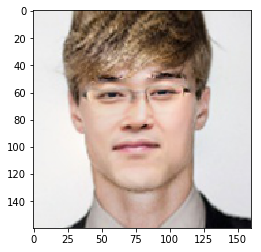

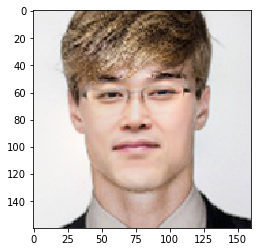

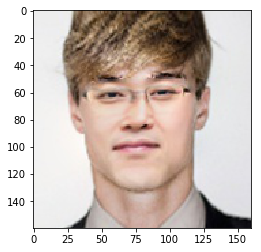

In [17]:
with tf.Graph().as_default():
    d_type = tf.float32
    image = tf.placeholder(d_type, shape=(None, w_size, w_size, 3), name= 'image')
    correct_x = tf.placeholder(d_type, (None, w_lm_num), name= 'correct_x')
    correct_y = tf.placeholder(d_type, (None, w_lm_num), name= 'correct_y')
    pred_x = tf.placeholder(d_type, (None, w_lm_num), name= 'pred_x')
    pred_y = tf.placeholder(d_type, (None, w_lm_num), name= 'pred_y')
    
    grids = tf.constant(w_xa, dtype=d_type, name= 'grids')
    zero_displacement = (tf.constant(zd[:, :, 0], dtype=tf.float32, name= 'zd_x'), 
                         tf.constant(zd[:, :, 1], dtype=tf.float32, name= 'zd_y'))

    warp = warp_tf(image, pred_x, pred_y, correct_x, correct_y, grids, w_grid_shape, zero_displacement)
    print(warp)
    out = tf.cast(warp, tf.uint8)

    #rbf_x = rbf_tf(pred_x, pred_y, correct_x, grids, w_batch_size)
    #rbf_y = rbf_tf(pred_x, pred_y, correct_y, grids, w_batch_size)
    
    with tf.Session() as sess :
        sess.run(tf.global_variables_initializer())
        
        feed_dict = {
            image : w_image.reshape(-1, w_size, w_size, 3),
            correct_x : correct_x_p.reshape(-1, w_lm_num),
            correct_y : correct_y_p.reshape(-1, w_lm_num),
            pred_x : pred_x_p.reshape(-1, w_lm_num),
            pred_y : pred_y_p.reshape(-1, w_lm_num)
        }
        
        #plt.scatter(w_n_lm[:, 0], w_n_lm[:, 1], s=10, marker='.', c='r')
        # plt.scatter(w_lm[:, 0][27:31], w_lm[:, 1][27:31], s=10, marker='.', c='r')
        # plt.scatter(w_n_lm[:, 0][27:31], w_n_lm[:, 1][27:31], s=10, marker='.', c='b')
        plt.pause(0.001)
        
        output = sess.run(out, feed_dict= feed_dict)
        plt.imshow(np.squeeze(output, axis=0))
        plt.show()
        
        plt.imshow(w_image)
        plt.show()
        
        warp_scipy(w_image, w_lm , 160)

# Training Model

In [114]:
epochs = 200
batch_size = 100

avgP_num = 1792
emb_num = 128
f_num = 1792

l_num = 68
zd_l_num = 74
t_size = 320
t_channel = 3

grid_y, grid_x = get_grids(t_size)
grid_shape = grid_x.shape
xa = np.asarray([a.flatten() for a in [grid_x, grid_y]], dtype=np.float_) # (2, 25600)
xa = np.asarray([xa for _ in range(0, batch_size)], dtype=np.float_) # (batch_size, 2, 25600)

# w_lm, w_n_lm = get_zero_displacement(w_size, w_landmarks)
# correct_x_p = w_lm[:, 0] 
# correct_y_p = w_lm[:, 1] 
# pred_x_p = w_n_lm[:, 0] 
# pred_y_p = w_n_lm[:, 1]

In [116]:
g = tf.Graph()
with g.as_default():
    # placeholder
    avgP_inputs = tf.placeholder(tf.float32, (None, avgP_num), name='avgP_inputs')
    
    l_x_labels = tf.placeholder(tf.float32, (None, l_num), name='l_x_labels')
    l_y_labels = tf.placeholder(tf.float32, (None, l_num), name='l_y_labels')
    t_labels = tf.placeholder(tf.float32, (None, t_size, t_size, t_channel), name='t_labels')
    w_labels = tf.placeholder(tf.float32, shape=(None, emb_num), name= 'w_labels')
    
    grids = tf.constant(xa, dtype=tf.float32, name= 'grids')
    
    # model
    F = F_layer(avgP_inputs, f_vector= f_num)
    
    (l_x_preds, l_y_preds) = landmark_decode(F, landmark_num= l_num)
    
    l_x_loss = tf.losses.mean_squared_error(l_x_labels, l_x_preds, reduction="weighted_mean")
    l_y_loss = tf.losses.mean_squared_error(l_y_labels, l_y_preds, reduction="weighted_mean")
    
    l_loss = tf.add(l_x_loss, l_y_loss)
    
    t_preds = texture_decode(F, t_size)
    t_loss = tf.losses.absolute_difference(t_labels, t_preds)
    
    warp = warp_tf(t_preds, l_x_preds, l_y_preds, l_x_labels, l_y_labels, grids, grid_shape, batch_size)
    # warp = tf.cast(warp, tf.uint8)
    
    variables = [v for v in tf.global_variables()]
    init = tf.variables_initializer(var_list= variables, name= 'init')

Tensor("Const_4:0", shape=(10,), dtype=float64)


In [120]:
with g.as_default():
    time_load_data = time.time()
    
    #facenet
    start_load_facenet = time.time()
    print("--- %s start load facenet ---" % (start_load_facenet))
    #facenet.load_model('./20171012')
    facenet.load_model('./20171012', input_map={"input:0": warp})
    print("--- %s facenet loaded ---" % (time.time() - start_load_facenet))

    # Get input and output tensors
    #f_inputs = tf.get_default_graph().get_tensor_by_name("input:0")
    #f_phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
    #f_avgP_logits = tf.get_default_graph().get_tensor_by_name("InceptionResnetV1/Logits/AvgPool_1a_8x8/AvgPool:0")
    w_preds = tf.get_default_graph().get_tensor_by_name("embeddings:0")
    
    w_loss = tf.losses.cosine_distance(tf.nn.l2_normalize(w_labels, 1), 
                                       tf.nn.l2_normalize(w_preds, 1), dim=1)
    
    total_cost = l_loss + t_loss + w_loss
    opt = tf.train.AdamOptimizer(0.001).minimize(total_cost)

--- 1507806208.1354082 start load facenet ---
Model filename: ./20171012
--- 9.078258991241455 facenet loaded ---


In [121]:
with g.as_default():
    with tf.Session() as sess:
        sess.run(init)

        start_test = time.time()
        
        total_size = len(images)            
        for i, (f_avgP, t_label_batch) in enumerate(zip(train_set, t_dataset.get_batches(batch_size))):
            start = i * batch_size
            end = min(start+batch_size, len(train_set) * batch_size)
            size = end - start

            l_labels = landmarks_frame.ix[start:end - 1, 1:].as_matrix().astype('float').reshape(-1, 2)
            
            feed_dict = {avgP_inputs : f_avgP.reshape(-1, avgP_vector),
                         l_x_labels : l_labels[:, 0].reshape(-1, l_num), 
                         l_y_labels : l_labels[:, 1].reshape(-1, l_num),
                         t_labels : t_label_batch}

            l_x_cost, l_y_cost, t_cost, w_cost, _ = sess.run([l_x_loss, l_y_loss, t_loss, w_loss, opt], feed_dict= feed_dict)

KeyboardInterrupt: 

In [43]:
# for op in tf.get_default_graph().get_operations():
#     print(str(op.name)) 